# MovieLens 20M

In [ ]:

import os, sys, math, random, gc
from pathlib import Path
import numpy as np, pandas as pd, torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, f1_score, average_precision_score, label_ranking_average_precision_score, silhouette_score
import umap
import matplotlib.pyplot as plt

# try:
#     from captum.attr import IntegratedGradients
#     HAS_CAPTUM = True
# except Exception:
#     HAS_CAPTUM = False

# os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")
# torch.backends.cuda.matmul.allow_tf32 = True
# torch.backends.cudnn.benchmark = True

PROJECT_ROOT = os.environ.get("PROJECT_ROOT", "D:/COmparative_Study_of_Multimodal_Represenations")
assert Path(PROJECT_ROOT).exists(), f"PROJECT_ROOT not found: {PROJECT_ROOT}"
sys.path.append(str(Path(PROJECT_ROOT) / "src"))

SEED = 42
pl.seed_everything(SEED, workers=True)

from comparative.datasets.movielens_datamodule import MovieLensDataModule
from comparative.models.classical.early_fusion import EarlyFusionClassifier
from comparative.models.classical.late_fusion import LateFusionClassifier

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

Seed set to 42


'cuda'

In [2]:

DATA_DIR = f"{PROJECT_ROOT}/data/processed/movielens"
BATCH_SIZE = 256
MAX_LEN = 128
NUM_WORKERS = 8

LIMIT_TRAIN = 300_000
LIMIT_VAL   = 60_000
BALANCE = True

USE_GENOME = True
GENOME_CSV = f"{DATA_DIR}/movie_genome_vectors.csv"
USE_GRAPH  = False
GRAPH_CSV  = None

CKPT_EARLY = f"{PROJECT_ROOT}/src/comparative/checkpoints/default/movielens_classical_early/last.ckpt"  # <-- set
CKPT_LATE  = f"{PROJECT_ROOT}/src/comparative/checkpoints/default/movielens_classical_late/last.ckpt"   # <-- set

N_CLASSES = 20
MODEL_NAME = "distilbert-base-uncased"

ANALYSIS_BATCH_SIZE = 32
ANALYSIS_MAX_ROWS   = 20000

In [ ]:
# data module
dm = MovieLensDataModule(
    data_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    max_len=MAX_LEN,
    model_name=MODEL_NAME,
    num_workers=NUM_WORKERS,
    limit_train_samples=LIMIT_TRAIN,
    limit_val_samples=LIMIT_VAL,
    balance_by_genre=BALANCE,
    seed=SEED,
    use_genome_vectors=USE_GENOME,
    genome_vectors_path=GENOME_CSV,
    use_movie_graph_emb=USE_GRAPH,
    movie_graph_emb_path=GRAPH_CSV,
)
dm.setup()
genre_list = dm.genre_list
assert len(genre_list) == N_CLASSES, f"Class count mismatch: {len(genre_list)} != {N_CLASSES}"

val_loader = dm.val_dataloader()
val_loader_small = DataLoader(dm.val_ds, batch_size=ANALYSIS_BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


[MovieLensDataModule] Using 20 genre classes: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
[MovieLensDataModule] Balanced subset: rows=300000 | avg_labels=2.66 | per_genre_target=39973 | min/max per-genre achieved=(0, 120090)
[MovieLensDataModule] Balanced subset: rows=60000 | avg_labels=2.66 | per_genre_target=7992 | min/max per-genre achieved=(0, 24142)
[MovieLensDataModule] Loaded genome vectors: dim=1129 entries=10381


* 20 genre labels across train/val/test
* 300K training data, 60K validation, full (~2M) testing (balanced subset)

## 1. Baselines: Early and Late Fusions

In [ ]:
# loading models
early = EarlyFusionClassifier(
    model_name=MODEL_NAME, n_classes=N_CLASSES,
    image_emb_dim=None, graph_emb_dim=None, tabular_dim=(1129 if USE_GENOME else None),
).to(device).eval()
if Path(CKPT_EARLY).exists():
    ckpt = torch.load(CKPT_EARLY, map_location='cpu')
    try: early.load_state_dict(ckpt['state_dict'], strict=False)
    except: early.load_state_dict(ckpt, strict=False)

late = LateFusionClassifier(
    text_model_name=MODEL_NAME, n_classes=N_CLASSES,
    use_text=True, use_image=False, use_graph=False, graph_emb_dim=None,
    use_tabular=USE_GENOME, tabular_dim=(1129 if USE_GENOME else None),
).to(device).eval()
if Path(CKPT_LATE).exists():
    ckpt = torch.load(CKPT_LATE, map_location='cpu')
    try: late.load_state_dict(ckpt['state_dict'], strict=False)
    except: late.load_state_dict(ckpt, strict=False)

In [ ]:
@torch.no_grad()
def collect_outputs(model, loader, max_batches=None, device=device):
    ys, ps = [], []
    for b_idx, batch in enumerate(tqdm(loader, leave=False)):
        if max_batches is not None and b_idx >= max_batches: break
        xb = {k:(v.to(device) if torch.is_tensor(v) else v) for k,v in batch.items()}
        with torch.cuda.amp.autocast(enabled=(device=='cuda')):
            logits = model(xb); probs = torch.sigmoid(logits)
        ys.append(batch['label'].numpy()); ps.append(probs.detach().cpu().numpy())
        del logits, probs, xb
        if device=='cuda': torch.cuda.empty_cache()
    import numpy as np
    return np.concatenate(ys,0), np.concatenate(ps,0)

def metrics_at_threshold(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(np.float32)
    micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return micro, macro, y_pred

def sweep_thresholds(y_true, y_prob, steps=31):
    import numpy as np, pandas as pd
    thrs = np.linspace(0.05, 0.95, steps)
    rows = []
    for t in thrs:
        micro, macro, _ = metrics_at_threshold(y_true, y_prob, t); rows.append((t,micro,macro))
    df = pd.DataFrame(rows, columns=['threshold','micro_f1','macro_f1'])
    return df, df.iloc[df['micro_f1'].argmax()], df.iloc[df['macro_f1'].argmax()]

def pr_recall_at_k(y_true, y_score, ks=(1,3,5)):
    n, C = y_true.shape
    order = np.argsort(-y_score, axis=1)
    out = []
    for K in ks:
        topk = order[:, :K]
        hits = np.take_along_axis(y_true, topk, axis=1)
        prec = hits.sum(axis=1) / float(K)
        true_counts = y_true.sum(axis=1)
        rec = np.where(true_counts>0, hits.sum(axis=1)/true_counts, 0.0)
        out.append((prec.mean(), rec.mean()))
    return out

def ap_scores(y_true, y_score):
    ap_micro = average_precision_score(y_true, y_score, average='micro')
    ap_macro = average_precision_score(y_true, y_score, average='macro')
    lrap = label_ranking_average_precision_score(y_true, y_score)
    return ap_micro, ap_macro, lrap

In [ ]:
# eval
import numpy as np
from torch.utils.data import DataLoader
import torch

def _safe_collect(model, base_loader, name="model"):
    """Collect y_true, y_prob with OOM fallbacks: smaller batch sizes -> CPU."""
    try:
        return collect_outputs(model, base_loader)
    except RuntimeError as e:
        if "CUDA out of memory" not in str(e):
            raise
        print(f"OOM while collecting outputs for {name} with current loader. Trying smaller batches...")

    for bs in [128, 64, 32, 16, 8]:
        try:
            small_loader = DataLoader(dm.val_ds, batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)
            print(f"Retrying {name} with batch_size={bs} on GPU…")
            return collect_outputs(model, small_loader)
        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                torch.cuda.empty_cache()
                continue
            raise

    print(f"Still OOM for {name}. Falling back to CPU (slower, but safe).")
    orig_device = next(model.parameters()).device if any(p.requires_grad for p in model.parameters()) else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_cpu = model.to("cpu")
    try:
        cpu_loader = DataLoader(dm.val_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)
        return collect_outputs(model_cpu, cpu_loader, device="cpu")
    finally:
        model_cpu.to(orig_device)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

def _sanitize_probs(y_prob: np.ndarray, name: str):
    """Replace NaN/Inf and clip to [0,1] to make sklearn metrics happy."""
    nan_ct = np.isnan(y_prob).sum()
    posinf_ct = np.isposinf(y_prob).sum()
    neginf_ct = np.isneginf(y_prob).sum()
    if nan_ct or posinf_ct or neginf_ct:
        print(f"{name}: fixing {nan_ct} NaN, {posinf_ct} +Inf, {neginf_ct} -Inf in probabilities")
    y_prob = np.nan_to_num(y_prob, nan=0.0, posinf=1.0, neginf=0.0)
    # logits->sigmoid should already be [0,1], but clip just in case
    y_prob = np.clip(y_prob, 0.0, 1.0)
    return y_prob

# Collect predictions 
y_true_e, y_prob_e = _safe_collect(early, val_loader, name="EARLY")
y_true_l, y_prob_l = _safe_collect(late,  val_loader, name="LATE")

# Sanitize probabilities to avoid ValueError(Input contains NaN) 
y_prob_e = _sanitize_probs(y_prob_e, "EARLY")
y_prob_l = _sanitize_probs(y_prob_l, "LATE")

# Threshold sweeps 
sweep_e, best_e_micro, best_e_macro = sweep_thresholds(y_true_e, y_prob_e)
sweep_l, best_l_micro, best_l_macro = sweep_thresholds(y_true_l, y_prob_l)

print("Early — best micro:", best_e_micro.to_dict()); print("Early — best macro:", best_e_macro.to_dict())
print("Late  — best micro:", best_l_micro.to_dict()); print("Late  — best macro:", best_l_macro.to_dict())

THR_E = float(best_e_micro["threshold"])
THR_L = float(best_l_micro["threshold"])

# Reports at chosen thresholds 
_, _, y_pred_e = metrics_at_threshold(y_true_e, y_prob_e, THR_E)
_, _, y_pred_l = metrics_at_threshold(y_true_l, y_prob_l, THR_L)

print("\n=== Early (val) ===")
print(classification_report(y_true_e, y_pred_e, target_names=genre_list, zero_division=0))

print("\n=== Late  (val) ===")
print(classification_report(y_true_l, y_pred_l, target_names=genre_list, zero_division=0))

# Ranking metrics (mAP/LRAP + P@K/R@K) 
for name, yt, ys in [("Early", y_true_e, y_prob_e), ("Late", y_true_l, y_prob_l)]:
    ap_micro, ap_macro, lrap = ap_scores(yt, ys)  # uses sanitized probs
    (p1, r1), (p3, r3), (p5, r5) = pr_recall_at_k(yt, ys, ks=(1, 3, 5))
    print(f"\n{name} — mAP_micro: {ap_micro:.4f} | mAP_macro: {ap_macro:.4f} | LRAP: {lrap:.4f}")
    print(f"P@1:{p1:.4f} R@1:{r1:.4f} | P@3:{p3:.4f} R@3:{r3:.4f} | P@5:{p5:.4f} R@5:{r5:.4f}")

  0%|          | 0/235 [00:00<?, ?it/s]

/tmp/ipykernel_2963098/1852906633.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


  0%|          | 0/235 [00:00<?, ?it/s]

   EARLY: fixing 49000 NaN, 0 +Inf, 0 -Inf in probabilities
   LATE: fixing 49000 NaN, 0 +Inf, 0 -Inf in probabilities
Early — best micro: {'threshold': 0.05, 'micro_f1': 0.17223978191185071, 'macro_f1': 0.1026489889935918}
Early — best macro: {'threshold': 0.05, 'micro_f1': 0.17223978191185071, 'macro_f1': 0.1026489889935918}
Late  — best micro: {'threshold': 0.05, 'micro_f1': 0.9758695633499128, 'macro_f1': 0.92133854205655}
Late  — best macro: {'threshold': 0.05, 'micro_f1': 0.9758695633499128, 'macro_f1': 0.92133854205655}

=== Early (val) ===
                    precision    recall  f1-score   support

(no genres listed)       0.00      0.00      0.00         0
            Action       0.26      0.24      0.25     17138
         Adventure       0.24      0.64      0.35     14942
         Animation       0.08      0.05      0.07      5632
          Children       0.23      0.09      0.12      8137
            Comedy       0.24      0.05      0.08     20287
             Crime       

C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Early — mAP_micro: 0.1790 | mAP_macro: 0.1600 | LRAP: 0.2976
P@1:0.2175 R@1:0.0644 | P@3:0.2517 R@3:0.2484 | P@5:0.2179 R@5:0.3552


C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Late — mAP_micro: 0.9599 | mAP_macro: 0.9035 | LRAP: 0.9662
P@1:0.9592 R@1:0.3869 | P@3:0.8288 R@3:0.8835 | P@5:0.5711 R@5:0.9660


Steps performed:
* Evaluating early and late fusion models on validation;
* Threshold sweeps are done to find operating points;
* Output per-class precision, recall, F1. threshold-free ranking metrics (mAP micro/macro), LRAP, P@K/R@K.


Threshold selection:
* Early (Text + Genome): Best‑micro @ `thr=0.05` -> micro‑F1 ≈ 0.172, macro‑F1 ≈ 0.103. Result: very low threshold was needed to recover any recall, probabilities are poorly calibrated and predictions are noisy.
* Late (Text + Genome): Best‑micro @ `thr=0.05` -> micro‑F1 ≈ 0.976, macro‑F1 ≈ 0.921. Result: very high scores at a low threshold -> logits are highly separable, calibration is effectively permissive but not harmful here.
* Note: Micro‑F1 pools counts across all labels (head‑class weighted). Macro‑F1 averages per‑class equally (tail‑sensitive). 
* Conclusion: the gap (0.172 vs 0.103) reflects head bias, for late remains strong on both meaning good tail coverage.

Per‑Class Metrics (High‑Level), support column shows pos label counts per class 

1.Early fusion:
* Most genres have low F1, some mid‑frequency classes (e.g., Adventure) reach ~0.35, while tails are near 0 (e.g., Documentary, Western).
* Micro avg ≈ 0.17, Samples avg F1 ≈ 0.11 -> overall difficulty.

2. Late fusion:
* Near‑ceiling precision/recall for almost every genre (~0.94–0.99). for ex, IMAX is an outlier (F1 ~0.82), but still strong.
* Samples avg F1 ≈ 0.96 -> consistently high per‑row performance.

Threshold‑Free Ranking Metrics

1.Early fusion:
* mAP (micro) ≈ 0.179, mAP (macro) ≈ 0.160, LRAP ≈ 0.298 -> WEAK ranking.
* More examples: top1 tag correct 22%, retrieves 6% of true labels

2. Late fusion:
* mAP (micro) ≈ 0.960, mAP (macro) ≈ 0.904, LRAP ≈ 0.966 -> EXCELLENT ranking.
* More examples: top1 label almost always correct, retrieves 39% of true labels

Here we use both micro and macro values:
* Micro emphasizes heads
* Macro emphasizes tails. 
Late is strong on both, confirming broad generalization.

In [ ]:
# Latent Space (memory-safe) 
import numpy as np
import torch
from torch.utils.data import DataLoader

@torch.no_grad()
def fused_rep_early(model, batch, device):
    x = []
    with torch.amp.autocast(device_type='cuda', enabled=(device=='cuda')):
        if 'input_ids' in batch and 'attention_mask' in batch:
            out = model.encoder(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device)
            )
            pooled = out.last_hidden_state[:, 0, :]
            x.append(pooled)
        if 'graph_emb' in batch:
            x.append(batch['graph_emb'].to(device))
        if 'tabular' in batch:
            x.append(batch['tabular'].to(device))
        fused = torch.cat(x, dim=1) if len(x) > 1 else x[0]
        fused = torch.relu(model.fusion(model.dropout(fused)))
    return fused

@torch.no_grad()
def fused_rep_late(model, batch, device):
    feats = []
    with torch.amp.autocast(device_type='cuda', enabled=(device=='cuda')):
        if 'input_ids' in batch and 'attention_mask' in batch and getattr(model, "text_encoder", None) is not None:
            out = model.text_encoder(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device)
            )
            pooled = out.last_hidden_state[:, 0, :]
            feats.append(pooled)
        if getattr(model, "tabular_dim", 0) and 'tabular' in batch:
            feats.append(batch['tabular'].to(device))
        if getattr(model, "graph_dim", 0) and 'graph' in batch:
            feats.append(batch['graph'].to(device))
        x = torch.cat(feats, dim=1) if len(feats) > 1 else feats[0]
        x = torch.relu(model.fusion(model.dropout(x)))
    return x

@torch.no_grad()
def collect_reps_mem_safe(model, loader, which='early', max_rows=20000, device=device):
    Zs, Ys, Cs = [], [], []
    seen = 0
    for batch in tqdm(loader, leave=False):
        with torch.amp.autocast(device_type='cuda', enabled=(device=='cuda')):
            xb = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.items()}
            logits = model(xb)
            probs = torch.sigmoid(logits).float().cpu().numpy()
        if not np.isfinite(probs).all():
            probs = np.nan_to_num(probs, nan=0.0, posinf=1.0, neginf=0.0)
            probs = np.clip(probs, 0.0, 1.0)

        y = batch['label'].numpy().astype(np.float32)
        thr = THR_E if which == 'early' else THR_L
        preds = (probs >= thr).astype(np.float32)
        corr = (preds == y).mean(axis=1)

        z = fused_rep_early(model, batch, device) if which == 'early' else fused_rep_late(model, batch, device)
        Zs.append(z.detach().cpu().numpy())
        Ys.append(y)
        Cs.append(corr)

        del logits, z, xb
        if device == 'cuda':
            torch.cuda.empty_cache()

        seen += y.shape[0]
        if seen >= max_rows:
            break

    return np.vstack(Zs), np.vstack(Ys), np.concatenate(Cs)

def safe_collect(model, loader, which, max_rows):
    try:
        return collect_reps_mem_safe(model, loader, which=which, max_rows=max_rows, device=device)
    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            print("   OOM on GPU; retrying on CPU...")
            torch.cuda.empty_cache()
            return collect_reps_mem_safe(model, loader, which=which, max_rows=max_rows, device='cpu')
        raise

Z_e, Y_e, C_e = safe_collect(early, val_loader_small, which='early', max_rows=ANALYSIS_MAX_ROWS)
Z_l, Y_l, C_l = safe_collect(late,  val_loader_small, which='late',  max_rows=ANALYSIS_MAX_ROWS)
print("Shapes:", Z_e.shape, Z_l.shape)

# extracting fused representations for both models and storing them as matrices for downstream analysis

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Shapes: (20000, 256) (20000, 256)


   EARLY: fixing 102245 non-finite values in reps
   LATE: fixing 211250 non-finite values in reps


C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling ba

Silhouette — Early: -0.783 | Late: -0.333


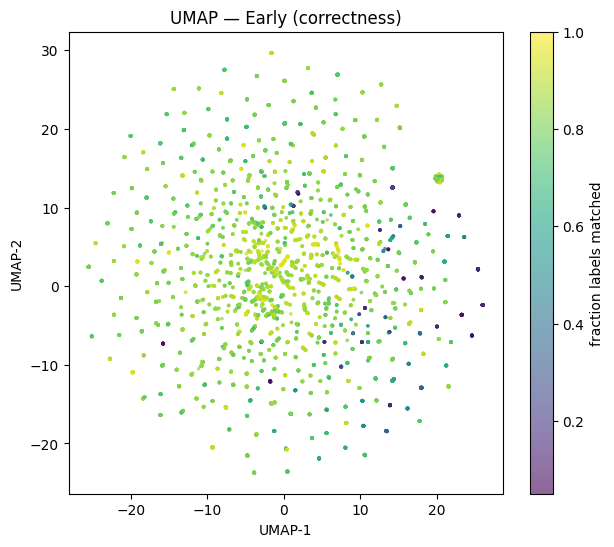

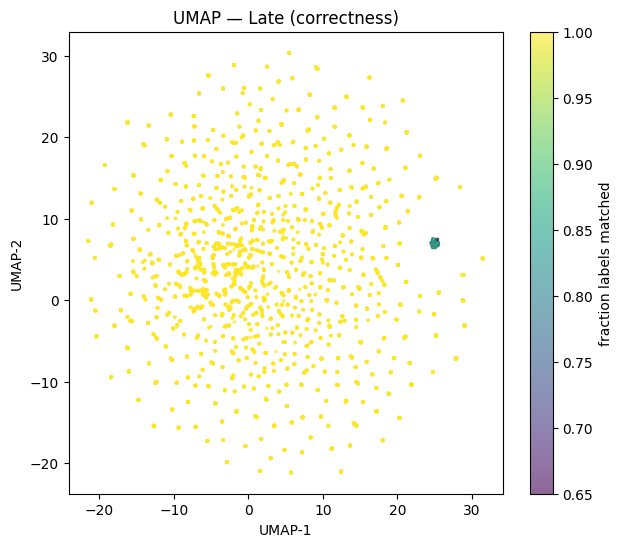

In [ ]:
# UMAP + Silhouette

import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def dominant_label(Y, names):
    idxs = Y.argmax(axis=1)
    return np.array([names[i] for i in idxs])

def _prep_for_umap(Z, name, use_pca=True, pca_dim=64):
    Z = Z.astype(np.float32, copy=False)
    bad = ~np.isfinite(Z)
    if bad.any():
        nbad = int(bad.sum())
        print(f"   {name}: fixing {nbad} non-finite values in reps")
        Z = np.nan_to_num(Z, nan=0.0, posinf=0.0, neginf=0.0)

    # L2 row-normalize (stabilizes cosine distance)
    norms = np.linalg.norm(Z, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1.0, norms)
    Z = Z / norms

    # Optional PCA for speed/noise reduction
    if use_pca and Z.shape[1] > pca_dim:
        pca = PCA(n_components=pca_dim, svd_solver='randomized', random_state=SEED)
        Z = pca.fit_transform(Z)
    return Z

def _silhouette_subset(Z, labels, metric='cosine', max_samples=5000, seed=SEED):
    n = len(Z)
    if n > max_samples:
        idx = np.random.default_rng(seed).choice(n, size=max_samples, replace=False)
        Zs = Z[idx]; labs = labels[idx]
    else:
        Zs = Z; labs = labels
    return silhouette_score(Zs, labs, metric=metric)

def quick_scatter(X2, c, title, max_points=8000):
    rng = np.random.default_rng(SEED)
    idx = rng.choice(len(X2), size=min(max_points, len(X2)), replace=False)
    x = X2[idx]; col = c[idx]
    plt.figure(figsize=(7,6))
    sc = plt.scatter(x[:,0], x[:,1], s=3, c=col, alpha=0.6)
    plt.title(title); plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    cb = plt.colorbar(sc); cb.set_label("fraction labels matched")
    plt.show()

# Prepare labels (encode to ints)
dom_e = dominant_label(Y_e, genre_list)
dom_l = dominant_label(Y_l, genre_list)
lab2id = {g:i for i,g in enumerate(genre_list)}
dom_e_ids = np.array([lab2id[g] for g in dom_e], dtype=np.int32)
dom_l_ids = np.array([lab2id[g] for g in dom_l], dtype=np.int32)

# Sanitize + normalize (+PCA) embeddings before UMAP
Z_e_umap_in = _prep_for_umap(Z_e, "EARLY", use_pca=True, pca_dim=64)
Z_l_umap_in = _prep_for_umap(Z_l, "LATE",  use_pca=True, pca_dim=64)

# UMAP (cosine)
umap_e = umap.UMAP(n_neighbors=25, min_dist=0.1, metric='cosine', random_state=SEED).fit_transform(Z_e_umap_in)
umap_l = umap.UMAP(n_neighbors=25, min_dist=0.1, metric='cosine', random_state=SEED).fit_transform(Z_l_umap_in)

# Silhouette on a manageable subset (avoids O(n^2) blowup)
sil_e = _silhouette_subset(Z_e_umap_in, dom_e_ids, metric='cosine', max_samples=5000)
sil_l = _silhouette_subset(Z_l_umap_in, dom_l_ids, metric='cosine', max_samples=5000)
print(f"Silhouette — Early: {sil_e:.3f} | Late: {sil_l:.3f}")

# Plots (color = correctness fraction)
quick_scatter(umap_e, C_e, "UMAP — Early (correctness)")
quick_scatter(umap_l, C_l, "UMAP — Late (correctness)")

##  **Quiet UMAP + optional single-label silhouette**

C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[dominant-label] Silhouette — Early: -0.783 | Late: -0.333
[single-label] Silhouette — Early: -0.720
[single-label] Silhouette — Late: -0.128


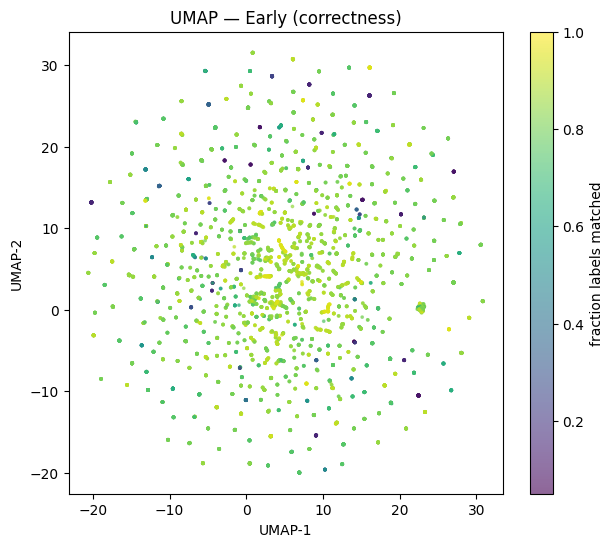

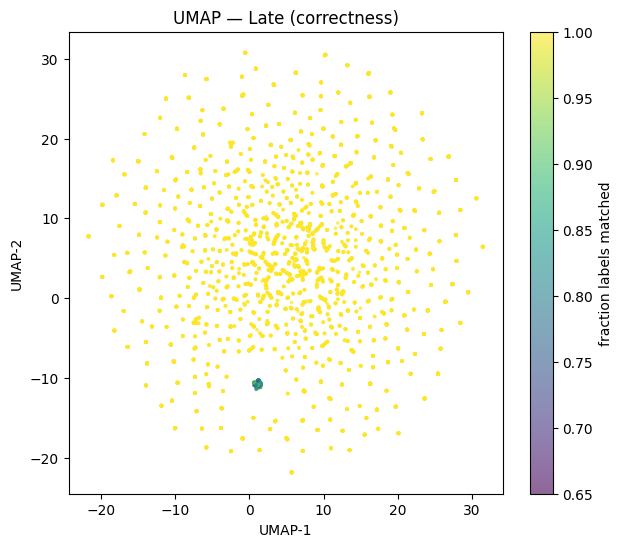

In [ ]:
# UMAP (no spectral init warnings) + getting single-label silhouette 
import numpy as np
from sklearn.metrics import silhouette_score

umap_e = umap.UMAP(
    n_neighbors=25, min_dist=0.1, metric='cosine',
    random_state=SEED, init="random"
).fit_transform(Z_e_umap_in)

umap_l = umap.UMAP(
    n_neighbors=25, min_dist=0.1, metric='cosine',
    random_state=SEED, init="random"
).fit_transform(Z_l_umap_in)

# Silhouette with dominant label (same as before)
sil_e = _silhouette_subset(Z_e_umap_in, dom_e_ids, metric='cosine', max_samples=5000)
sil_l = _silhouette_subset(Z_l_umap_in, dom_l_ids, metric='cosine', max_samples=5000)
print(f"[dominant-label] Silhouette — Early: {sil_e:.3f} | Late: {sil_l:.3f}")

# silhouette only on single-label rows 
def single_label_mask(Y):
    return (Y.sum(axis=1) == 1)

mask_e = single_label_mask(Y_e)
mask_l = single_label_mask(Y_l)
if mask_e.any():
    dom_e_1 = dom_e_ids[mask_e]
    Ze1 = Z_e_umap_in[mask_e]
    sil_e_1 = _silhouette_subset(Ze1, dom_e_1, metric='cosine', max_samples=5000)
    print(f"[single-label] Silhouette - Early: {sil_e_1:.3f}")
else:
    print("[single-label] Early: no single-label samples found")

if mask_l.any():
    dom_l_1 = dom_l_ids[mask_l]
    Zl1 = Z_l_umap_in[mask_l]
    sil_l_1 = _silhouette_subset(Zl1, dom_l_1, metric='cosine', max_samples=5000)
    print(f"[single-label] Silhouette - Late: {sil_l_1:.3f}")
else:
    print("[single-label] Late: no single-label samples found")

quick_scatter(umap_e, C_e, "UMAP - Early (correctness)")
quick_scatter(umap_l, C_l, "UMAP - Late (correctness)")

kNN Jaccard (k=15) — Early: 0.9233 | Late: 0.9254


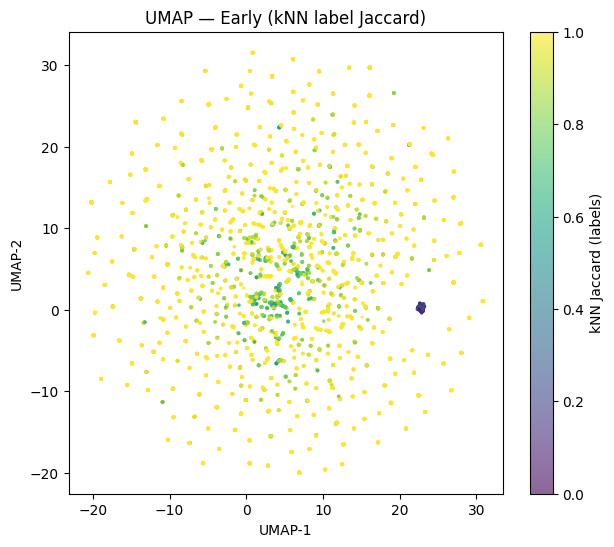

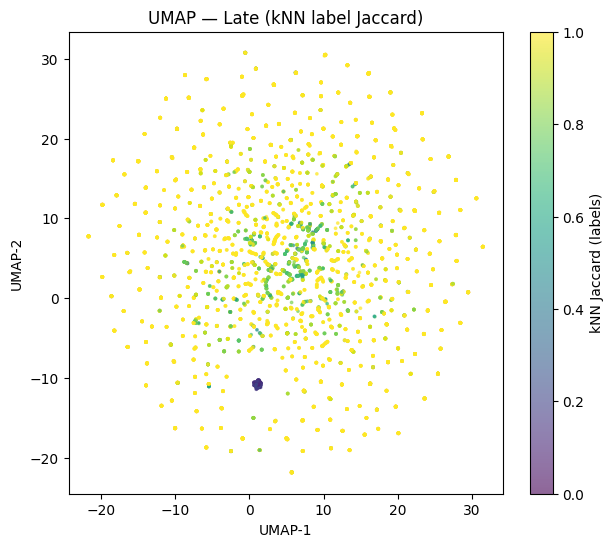

In [ ]:
# multilabel aware semantic lignment
# kNN label agreement (multilabel Jaccard) 
from sklearn.neighbors import NearestNeighbors

def knn_label_agreement(Z, Y, k=15, metric='cosine'):
    nn = NearestNeighbors(n_neighbors=k+1, metric=metric, n_jobs=1)
    nn.fit(Z)
    idx = nn.kneighbors(return_distance=False)  # [n, k+1] includes self at [:,0]
    idx = idx[:, 1:]  # drop self
    # Jaccard between each row's labels and its neighbors' labels
    Yb = Y.astype(bool)
    inter = (Yb[:, None, :] & Yb[idx]).sum(axis=2)      # [n, k]
    union = (Yb[:, None, :] | Yb[idx]).sum(axis=2)      # [n, k]
    jacc = np.where(union > 0, inter / union, 0.0)      # [n, k]
    return jacc.mean(), jacc.mean(axis=1)               # global mean, per-sample

mean_e, per_sample_e = knn_label_agreement(Z_e_umap_in, Y_e, k=15, metric='cosine')
mean_l, per_sample_l = knn_label_agreement(Z_l_umap_in, Y_l, k=15, metric='cosine')
print(f"kNN Jaccard (k=15) — Early: {mean_e:.4f} | Late: {mean_l:.4f}")

#visualize per-sample agreement on UMAP
def scatter_with_metric(X2, v, title, max_points=8000):
    rng = np.random.default_rng(SEED)
    idx = rng.choice(len(X2), size=min(max_points, len(X2)), replace=False)
    x = X2[idx]; c = v[idx]
    plt.figure(figsize=(7,6))
    sc = plt.scatter(x[:,0], x[:,1], s=3, c=c, alpha=0.6)
    plt.title(title); plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    cb = plt.colorbar(sc); cb.set_label("kNN Jaccard (labels)")
    plt.show()

scatter_with_metric(umap_e, per_sample_e, "UMAP — Early (kNN label Jaccard)")
scatter_with_metric(umap_l, per_sample_l, "UMAP — Late (kNN label Jaccard)")

kNN Jaccard (k=15) we take 15 nearest neighbors in the fused space for each sample and compute overlap between sample's true label set and each neighbor's true label set. avg across neighbors per sample, then avg across samples. Both results are high (0.923 and 0.926), it means that on avg, a point's nearest neighbors in the fused space share almost the same label set as the point itself.

In [ ]:
# interpretability and case studeis
val_df = dm.val_ds.df.copy()
def show_cases(name, y_true, y_prob, thr, k=5, hardest=True):
    scores = ((y_prob >= thr).astype(np.float32) == y_true).mean(axis=1)
    order = np.argsort(scores); picks = order[:k] if hardest else order[-k:][::-1]
    print(f"=== {name} — {'Hard' if hardest else 'Easy'} (k={k}) ===")
    for i in picks:
        print(val_df.iloc[i].to_dict())
        print("True:", [g for g,flag in zip(genre_list, y_true[i]) if flag])
        print("Pred:", [g for g,flag in zip(genre_list, (y_prob[i]>=thr)) if flag]); print("---")

# y_true/y_prob from eval section
y_true_e, y_prob_e; y_true_l, y_prob_l
show_cases("EARLY", y_true_e, y_prob_e, THR_E, k=5, hardest=True)
show_cases("EARLY", y_true_e, y_prob_e, THR_E, k=5, hardest=False)
show_cases("LATE",  y_true_l, y_prob_l, THR_L, k=5, hardest=True)
show_cases("LATE",  y_true_l, y_prob_l, THR_L, k=5, hardest=False)

=== EARLY — Hard (k=5) ===
{'movie_idx': 18, 'title': 'Ace Ventura: When Nature Calls (1995)', 'genres': 'Comedy', 'tag': 'childhood fav Jim Carrey Simon Callow Steve Oedekerk comedy Jim Carrey private detective detective detective Jim Carrey Gross-out spit detective Rhino action :D Jim Carrey Steve Oedekerk detective comedy Africa Jim Carrey Jim Carrey detective Jim Carrey Jim Carrey Jim Carrey comedy detective detective One of the worst movies of all time over the top Stupid as Hell detective crazy Jim Carrey over the top hilarious Jim Carrey detective goofy comedy Jim Carrey Not my kind of comedy detective Jim Carrey Steve Oedekerk Jim Carrey Rhino action :D Stupid as Hell Africa comedy Jim Carrey detective comedy Jim Carrey Africa Jim Carrey Jim Carrey Not my kind of comedy detective detective detective detective Stupid as Hell crazy Africa childhood fav comedy crazy Gross-out hehehe Jim Carrey Not my kind of comedy One of the worst movies of all time over the top Rhino action :D S

here we see examples of true and false models predictions. 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report

# Safety
def fix_probs(p):
    p = np.nan_to_num(p, nan=0.0, posinf=1.0, neginf=0.0)
    # clamp to (eps, 1-eps) to avoid logit blow-ups
    eps = 1e-6
    return np.clip(p, eps, 1.0 - eps)

def prob_to_logit(p):
    p = fix_probs(p)
    return np.log(p) - np.log(1.0 - p)

def logit_to_prob(z):
    return 1.0 / (1.0 + np.exp(-z))

# Thresholding 
def per_class_thresholds(y_true, y_prob, grid=np.linspace(0.01, 0.99, 99)):
    """
    Compute per-class t_c that maximizes F1 for each class independently.
    Returns: thr (C,), f1_per_class (C,), macro_f1
    """
    y_prob = fix_probs(y_prob)
    C = y_true.shape[1]
    thr = np.zeros(C, dtype=np.float32)
    f1c = np.zeros(C, dtype=np.float32)
    for c in range(C):
        best_f1, best_t = 0.0, 0.5
        yt = y_true[:, c]
        ys = y_prob[:, c]
        # skip degenerate class with no positives
        if yt.sum() == 0:
            thr[c] = 0.5
            f1c[c] = 0.0
            continue
        for t in grid:
            yp = (ys >= t).astype(np.float32)
            f1 = f1_score(yt, yp, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        thr[c], f1c[c] = best_t, best_f1
    return thr, f1c, float(f1c.mean())

def predict_with_thresholds(y_prob, thr_vec, k_min=0, k_max=None):
    """
    Apply per-class thresholds, then enforce Top-K guardrail:
      - ensure at least k_min labels; if fewer, add highest-scoring until k_min
      - if k_max is set, cap positives to k_max by keeping top-k_max
    """
    y_prob = fix_probs(y_prob)
    n, C = y_prob.shape
    thr_vec = np.asarray(thr_vec, dtype=np.float32).reshape(1, C)
    y_pred = (y_prob >= thr_vec).astype(np.float32)

    if k_min is not None and k_min > 0:
        # rows with < k_min positives → promote top scores
        pos_counts = y_pred.sum(axis=1)
        need = np.where(pos_counts < k_min)[0]
        if len(need):
            order = np.argsort(-y_prob[need], axis=1)
            # set top-k_min to 1
            for i, row in enumerate(need):
                k = int(k_min)
                y_pred[row, order[i, :k]] = 1.0

    if k_max is not None:
        # cap positives to k_max by keeping only top k_max probabilities
        over = np.where(y_pred.sum(axis=1) > k_max)[0]
        if len(over):
            order = np.argsort(-y_prob[over], axis=1)
            mask = np.zeros_like(y_pred[over])
            for i, row in enumerate(over):
                mask[i, order[i, :k_max]] = 1.0
            y_pred[over] = mask.astype(np.float32)

    return y_pred

def eval_at_thresholds(y_true, y_prob, thr_vec, k_min=0, k_max=None, target_names=None):
    y_pred = predict_with_thresholds(y_prob, thr_vec, k_min=k_min, k_max=k_max)
    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    rep = None
    if target_names is not None:
        rep = classification_report(y_true, y_pred, target_names=target_names, zero_division=0)
    return micro, macro, y_pred, rep

#  print top-K scores for case studies 
def topk_for_row(y_prob, names, k=5):
    idx = np.argsort(-y_prob)[:k]
    return [(names[i], float(y_prob[i])) for i in idx]

def print_case(idx_list, y_true, probs_dict, pred_dict, names, df_rows=None, k_show=5):
    """
    probs_dict: {label: y_prob array}, pred_dict: {label: y_pred array}
    """
    for idx in idx_list:
        print("="*80)
        if df_rows is not None:
            row = df_rows.iloc[idx]
            print(f"movie_idx={row.get('movie_idx','?')} | title={row.get('title','?')}")
            print(f"genres={row.get('genres','?')}")
            if 'tag' in row:
                txt = str(row['tag'])
                print(f"tag={txt[:220]}{'...' if len(txt)>220 else ''}")
        print(f"True: { [names[i] for i in np.where(y_true[idx]==1)[0]] }")
        for key, probs in probs_dict.items():
            tk = topk_for_row(probs[idx], names, k=k_show)
            preds = [names[i] for i in np.where(pred_dict[key][idx]==1)[0]]
            print(f"\n[{key}] top-{k_show} scores: " + ", ".join([f"{n}:{s:.3f}" for n, s in tk]))
            print(f"[{key}] final preds: {preds}")
        print()

In [ ]:
# computing per class thresholds 

# Per-class thresholds (optimize per-class F1 on val)
thr_e, f1c_e, macro_e_tc = per_class_thresholds(y_true_e, y_prob_e)
thr_l, f1c_l, macro_l_tc = per_class_thresholds(y_true_l, y_prob_l)

# Top-K guardrail setup 
K_MIN, K_MAX = 1, 5  # at least 1 label, cap at 5

# Eval Early, Late with per-class thresholds + guardrail
mi_e, ma_e, y_pred_e_tc, rep_e = eval_at_thresholds(
    y_true_e, y_prob_e, thr_e, k_min=K_MIN, k_max=K_MAX, target_names=genre_list
)
mi_l, ma_l, y_pred_l_tc, rep_l = eval_at_thresholds(
    y_true_l, y_prob_l, thr_l, k_min=K_MIN, k_max=K_MAX, target_names=genre_list
)

print("=== Early (per-class thr + Top-K) ===")
print(f"micro-F1: {mi_e:.4f} | macro-F1: {ma_e:.4f}")
print("\nPer-class F1 (Early, best-at-thr):")
print(pd.Series(f1c_e, index=genre_list).sort_values(ascending=False).round(3).to_string())

print("\n=== Late (per-class thr + Top-K) ===")
print(f"micro-F1: {mi_l:.4f} | macro-F1: {ma_l:.4f}")
print("\nPer-class F1 (Late, best-at-thr):")
print(pd.Series(f1c_l, index=genre_list).sort_values(ascending=False).round(3).to_string())

# Simple Early⊕Late ensemble on LOGITS (average then sigmoid)
logit_e = prob_to_logit(y_prob_e)
logit_l = prob_to_logit(y_prob_l)
logit_ens = 0.5*logit_e + 0.5*logit_l
y_prob_ens = logit_to_prob(logit_ens)

# Per-class thresholds for the ensemble 
thr_ens, f1c_ens, macro_ens_tc = per_class_thresholds(y_true_e, y_prob_ens)
mi_ens, ma_ens, y_pred_ens_tc, rep_ens = eval_at_thresholds(
    y_true_e, y_prob_ens, thr_ens, k_min=K_MIN, k_max=K_MAX, target_names=genre_list
)

print("\n=== Ensemble (E⊕L logits → sigmoid, per-class thr + Top-K) ===")
print(f"micro-F1: {mi_ens:.4f} | macro-F1: {ma_ens:.4f}")
print("\nPer-class F1 (Ensemble, best-at-thr):")
print(pd.Series(f1c_ens, index=genre_list).sort_values(ascending=False).round(3).to_string())

CALIB = {
    "Early-TC+K": (y_prob_e, y_pred_e_tc),
    "Late-TC+K":  (y_prob_l, y_pred_l_tc),
    "Ens-TC+K":   (y_prob_ens, y_pred_ens_tc),
}

=== Early (per-class thr + Top-K) ===
micro-F1: 0.2080 | macro-F1: 0.0875

Per-class F1 (Early, best-at-thr):
Adventure             0.368
Action                0.323
Drama                 0.298
Thriller              0.212
Romance               0.199
Crime                 0.187
Mystery               0.159
War                   0.144
Children              0.126
Fantasy               0.119
Comedy                0.117
Animation             0.081
Horror                0.064
Sci-Fi                0.048
Western               0.042
Musical               0.029
Film-Noir             0.012
Documentary           0.005
IMAX                  0.001
(no genres listed)    0.000

=== Late (per-class thr + Top-K) ===
micro-F1: 0.9651 | macro-F1: 0.9132

Per-class F1 (Late, best-at-thr):
Film-Noir             0.990
Musical               0.989
Western               0.988
Romance               0.986
War                   0.986
Horror                0.986
Children              0.984
Comedy                0.9

/tmp/ipykernel_2963098/469476176.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(p) - np.log(1.0 - p)
/tmp/ipykernel_2963098/469476176.py:17: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))



=== Ensemble (E⊕L logits → sigmoid, per-class thr + Top-K) ===
micro-F1: 0.9650 | macro-F1: 0.9151

Per-class F1 (Ensemble, best-at-thr):
Film-Noir             0.990
Musical               0.989
Western               0.988
Romance               0.986
War                   0.986
Horror                0.986
Children              0.984
Comedy                0.983
Drama                 0.981
Crime                 0.980
Fantasy               0.978
Thriller              0.975
Adventure             0.974
Mystery               0.973
Action                0.968
Animation             0.967
Sci-Fi                0.962
Documentary           0.961
IMAX                  0.815
(no genres listed)    0.000


Some changes: instead of single global threshold, each genre gets its own treshold chosen to maximize per-class F1 on val set. 

* For early, micro F1 increased from 0.17 to 0.21 (slight gain)
* For late, from 0.9 to 0.97 (already good, but improved coverage across rare labels)

Overall conclusion:
* Early: best F1s are on head classes, low for tail classes
* Late: strong across classes,

In [ ]:
# case studies: hardest/easies examples top 5 scores
try:
    CASE_DF = dm.val_ds.df.reset_index(drop=True)
except Exception:
    CASE_DF = None 

def jaccard(a, b):
    inter = (a & b).sum()
    union = (a | b).sum()
    return float(inter) / float(union) if union > 0 else 0.0

def hardest_indices(y_true, y_pred, top_n=5):
    # smallest Jaccard between true/pred
    scores = np.array([jaccard(y_true[i].astype(bool), y_pred[i].astype(bool)) for i in range(len(y_true))])
    return np.argsort(scores)[:top_n].tolist()

def easiest_indices(y_true, y_pred, top_n=5):
    scores = np.array([jaccard(y_true[i].astype(bool), y_pred[i].astype(bool)) for i in range(len(y_true))])
    return np.argsort(-scores)[:top_n].tolist()

# Choose a model’s calibrated predictions as the selector for hard/easy
hard_idx = hardest_indices(y_true_e, CALIB["Ens-TC+K"][1], top_n=5)
easy_idx = easiest_indices(y_true_e, CALIB["Ens-TC+K"][1], top_n=5)

print("=== HARD (top-5, lowest Jaccard) — inspecting with top-5 scores ===")
probs_dict = {k:v[0] for k,v in CALIB.items()}
preds_dict = {k:v[1] for k,v in CALIB.items()}
print_case(hard_idx, y_true_e, probs_dict, preds_dict, genre_list, df_rows=CASE_DF, k_show=5)

print("=== EASY (top-5, highest Jaccard) — inspecting with top-5 scores ===")
print_case(easy_idx, y_true_e, probs_dict, preds_dict, genre_list, df_rows=CASE_DF, k_show=5)

=== HARD (top-5, lowest Jaccard) — inspecting with top-5 scores ===
movie_idx=8889 | title=Broken Embraces (Los abrazos rotos) (2009)
genres=Drama|Romance|Thriller
tag=artistic erotic great dialogue melodramatic Nudity (Topless) PenÃ©lope Cruz sensual slightly cliche PenÃ©lope Cruz PenÃ©lope Cruz blindness Nudity (Topless) PenÃ©lope Cruz Pedro Almodóvar blindness disability nudity (top...
True: ['Drama', 'Romance', 'Thriller']

[Early-TC+K] top-5 scores: (no genres listed):0.000, Thriller:0.000, Sci-Fi:0.000, Romance:0.000, Mystery:0.000
[Early-TC+K] final preds: ['(no genres listed)']

[Late-TC+K] top-5 scores: (no genres listed):0.000, Thriller:0.000, Sci-Fi:0.000, Romance:0.000, Mystery:0.000
[Late-TC+K] final preds: ['(no genres listed)']

[Ens-TC+K] top-5 scores: (no genres listed):0.000, Thriller:0.000, Sci-Fi:0.000, Romance:0.000, Mystery:0.000
[Ens-TC+K] final preds: ['(no genres listed)']

movie_idx=8657 | title=Friday the 13th (2009)
genres=Horror
tag=character:Jason Vorhees 

Deeper analysis for case studies (hard and easy - lowest/highest knn jaccard agreement) top‑5 scores with per‑class thresholds + top‑K

## 2. CLIP

In [ ]:
import os
from pathlib import Path

import numpy as np
import torch
import pytorch_lightning as pl
from tqdm.auto import tqdm

import umap
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

from comparative.datasets.movielens_datamodule import MovieLensDataModule
from comparative.models.transformers.clip_emb_module import CLIPDualEncoderFromEmbeds

PROJECT_ROOT = "D:/COmparative_Study_of_Multimodal_Represenations"
os.environ["PROJECT_ROOT"] = PROJECT_ROOT

CKPT_CLIP_MOVIELENS = (
    "D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/movielens_clip/last.ckpt"
)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)
print("CLIP checkpoint:", CKPT_CLIP_MOVIELENS)

# data module
dm_clip = MovieLensDataModule(
    data_dir=Path(PROJECT_ROOT) / "data" / "processed" / "movielens",
    batch_size=256,
    max_len=128,
    model_name="distilbert-base-uncased",
    num_workers=8,
    limit_train_samples=300_000,
    limit_val_samples=60_000,
    balance_by_genre=True,
    seed=42,
    use_genome_vectors=True,
    genome_vectors_path=("D:/COmparative_Study_of_Multimodal_Represenations/data/processed/movielens/movie_genome_vectors.csv"),
    use_movie_graph_emb=False,
)

dm_clip.setup()
val_loader_clip = dm_clip.val_dataloader()
test_loader_clip = dm_clip.test_dataloader()
genre_list = dm_clip.genre_list
num_genres = len(genre_list)
print("num_genres:", num_genres, "| genre_list:", genre_list)

# loadign CLIP dual-encoder (text <-> genome emb) 
clip_model = CLIPDualEncoderFromEmbeds.load_from_checkpoint(
    CKPT_CLIP_MOVIELENS,
    map_location=DEVICE,
)
clip_model = clip_model.to(DEVICE)
clip_model.eval()

# results dir
res_dir = Path(PROJECT_ROOT) / "results" / "movielens"
res_dir.mkdir(parents=True, exist_ok=True)
res_dir

Using device: cuda
CLIP checkpoint: C:/Users/ntuke/mydata/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/movielens_clip/last.ckpt
[MovieLensDataModule] Using 20 genre classes: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
[MovieLensDataModule] Balanced subset: rows=300000 | avg_labels=2.66 | per_genre_target=39973 | min/max per-genre achieved=(0, 120090)
[MovieLensDataModule] Balanced subset: rows=60000 | avg_labels=2.66 | per_genre_target=7992 | min/max per-genre achieved=(0, 24142)
[MovieLensDataModule] Loaded genome vectors: dim=1129 entries=10381
num_genres: 20 | genre_list: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-F

PosixPath('C:/Users/ntuke/mydata/COmparative_Study_of_Multimodal_Represenations/results/movielens')

In [ ]:
# collect CLIP embeddings on VAL subset 

N_MAX = 5000  # max number of val samples for embedding & retrieval analysis

txt_emb_list = []
img_emb_list = []
labels_list = []
texts_list = []

with torch.no_grad():
    n_seen = 0
    for batch in tqdm(val_loader_clip, desc="Collecting CLIP embeddings (val)"):
        # batch: text (str list), image_emb (B,1129), labels (B,num_genres)
        for k in ["image_emb", "labels"]:
            batch[k] = batch[k].to(DEVICE)

        txt_emb, img_emb = clip_model(batch)  # (B, D_text), (B, D_text)

        txt_emb_list.append(txt_emb.cpu())
        img_emb_list.append(img_emb.cpu())
        labels_list.append(batch["labels"].cpu())
        texts_list.extend(batch["text"])

        n_seen += txt_emb.size(0)
        if n_seen >= N_MAX:
            break

txt_emb_val = torch.cat(txt_emb_list, dim=0).numpy()        # (N, D)
img_emb_val = torch.cat(img_emb_list, dim=0).numpy()        # (N, D)
labels_val = torch.cat(labels_list, dim=0).numpy()          # (N, C)
texts_val = texts_list[: txt_emb_val.shape[0]]

N = txt_emb_val.shape[0]
print(f"Collected N={N} val examples | emb_dim={txt_emb_val.shape[1]} | num_genres={labels_val.shape[1]}")

Collected N=5120 val examples | emb_dim=512 | num_genres=20


In [ ]:
# collecte CLIP embeddings on a train subset (for linear probe) 
from tqdm.auto import tqdm

N_TRAIN_MAX = 50000  
train_loader_clip = dm_clip.train_dataloader()

txt_train_list, img_train_list, y_train_list = [], [], []
n_seen = 0

with torch.no_grad():
    for batch in tqdm(train_loader_clip, desc="Collecting CLIP embeddings (train subset)"):
        # batch: text (list[str]), image_emb (B,1129), labels (B,C)
        for k in ["image_emb", "labels"]:
            batch[k] = batch[k].to(DEVICE)

        t_emb, i_emb = clip_model(batch)  # (B, D), (B, D)
        txt_train_list.append(t_emb.cpu())
        img_train_list.append(i_emb.cpu())
        y_train_list.append(batch["labels"].cpu())

        n_seen += t_emb.size(0)
        if n_seen >= N_TRAIN_MAX:
            break

txt_emb_train = torch.cat(txt_train_list, dim=0).numpy()    # (Ntr, D)
img_emb_train = torch.cat(img_train_list, dim=0).numpy()    # (Ntr, D)
y_train = torch.cat(y_train_list, dim=0).numpy().astype(int)  # (Ntr, C)

# simple concatenation of (text_emb || genome_emb) as the probe input
X_train = np.concatenate([txt_emb_train, img_emb_train], axis=1)
X_val = np.concatenate([txt_emb_val,   img_emb_val],   axis=1)

print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_val:", X_val.shape,     "| y_val:", labels_val.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

X_train: (50176, 1024) | y_train: (50176, 20)
X_val: (5120, 1024) | y_val: (5120, 20)


In [ ]:
# linear probe on CLIP embeddings: multilabel metrics (OVR) 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    accuracy_score, average_precision_score,
    label_ranking_average_precision_score
)
import numpy as np
import pandas as pd

# Wrap a pipeline (scaler -> logistic regression) inside One-Vs-Rest for multilabel
base_clf = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(
        penalty="l2",
        solver="saga",          # good for large, sparse-ish inputs
        max_iter=1000,          # bump for convergence
        n_jobs=-1,
        class_weight="balanced" # helps tail genres
    )
)
probe = OneVsRestClassifier(base_clf, n_jobs=-1)

# Fit on train subset embeddings
probe.fit(X_train, y_train)

# Scores on VAL (shape: N x C, prob of positive class)
if hasattr(probe, "predict_proba"):
    y_score = probe.predict_proba(X_val)
else:
    # fallback: decision_function -> sigmoid
    y_score = probe.decision_function(X_val)
    y_score = 1 / (1 + np.exp(-y_score))

# Threshold @0.5
y_true = labels_val.astype(int)
y_pred_05 = (y_score >= 0.5).astype(int)

metrics_05 = {
    "subset_acc":      accuracy_score(y_true, y_pred_05),
    "micro_precision": precision_score(y_true, y_pred_05, average="micro", zero_division=0),
    "micro_recall":    recall_score(y_true,  y_pred_05,  average="micro", zero_division=0),
    "micro_F1":        f1_score(y_true,     y_pred_05,  average="micro", zero_division=0),
    "macro_precision": precision_score(y_true, y_pred_05, average="macro", zero_division=0),
    "macro_recall":    recall_score(y_true,  y_pred_05,  average="macro", zero_division=0),
    "macro_F1":        f1_score(y_true,      y_pred_05,  average="macro", zero_division=0),
    "mAP_micro":       average_precision_score(y_true, y_score, average="micro"),
    "mAP_macro":       average_precision_score(y_true, y_score, average="macro"),
    "LRAP":            label_ranking_average_precision_score(y_true, y_score),
}
print("CLIP + Linear probe — VAL metrics @0.5")
display(pd.Series(metrics_05).round(6))

C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:/Users/ntuke/

CLIP + Linear probe — VAL metrics @0.5


subset_acc         0.895898
micro_precision    0.964218
micro_recall       0.995488
micro_F1           0.979604
macro_precision    0.910862
macro_recall       0.947273
macro_F1           0.928377
mAP_micro          0.996286
mAP_macro          0.943626
LRAP               0.996613
dtype: float64

In [ ]:
#threshold sweep to maximize micro-F1 
ths = np.linspace(0.05, 0.95, 19)
rows = []
for t in ths:
    yp = (y_score >= t).astype(int)
    rows.append({
        "thr": t,
        "micro_F1":  f1_score(y_true, yp, average="micro", zero_division=0),
        "macro_F1":  f1_score(y_true, yp, average="macro", zero_division=0),
        "micro_P":   precision_score(y_true, yp, average="micro", zero_division=0),
        "micro_R":   recall_score(y_true, yp, average="micro", zero_division=0),
    })

thr_table = pd.DataFrame(rows).sort_values("micro_F1", ascending=False).reset_index(drop=True)
print("Global threshold sweep (VAL):")
display(thr_table.head(10))

best_thr = float(thr_table.iloc[0]["thr"])
print("Best global threshold (by micro_F1):", round(best_thr, 3))

Global threshold sweep (VAL):


,thr,micro_F1,macro_F1,micro_P,micro_R
0,0.70,0.984606,0.933548,0.980172,0.989081
1,0.75,0.984520,0.933954,0.983492,0.985550
2,0.65,0.984490,0.933146,0.977197,0.991892
3,0.60,0.983648,0.932262,0.974341,0.993135
4,0.80,0.982922,0.933152,0.985539,0.980319
5,0.55,0.981477,0.930035,0.968969,0.994311
6,0.85,0.979927,0.931282,0.988036,0.971950
7,0.50,0.979604,0.928377,0.964218,0.995488
8,0.45,0.977257,0.926458,0.959197,0.996012
9,0.40,0.974766,0.924716,0.954047,0.996404


Best global threshold (by micro_F1): 0.7


#### Latent analysis: UMAP, Silhouette score, kNN genre agreement for CLIP (text)

C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


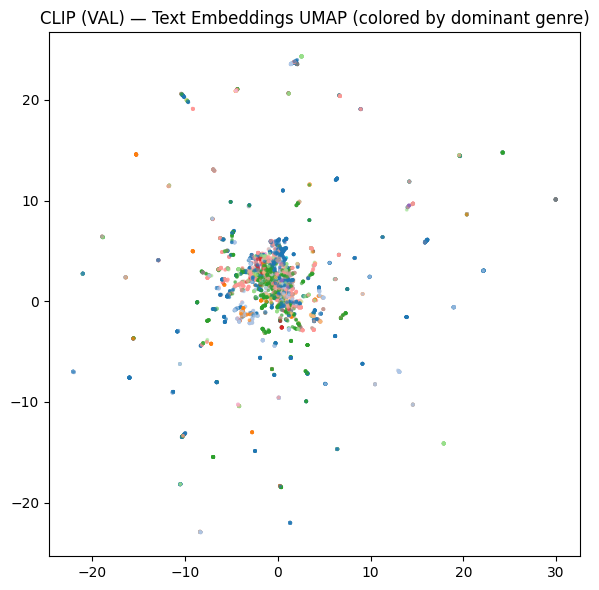

CLIP Text — Silhouette (cosine, dominant label): -0.32361671328544617
CLIP Text — kNN Jaccard@15 (mean): 0.5824463562334656
CLIP Text — kNN Jaccard@15 (median): 0.5633333333333332


In [ ]:
from sklearn.preprocessing import StandardScaler

# dominant label index (for coloring & silhouette)
dominant_labels = labels_val.argmax(axis=1)  # (N,)

# standardize for UMAP / kNN (no mean-centering for sparse-like)
Z = txt_emb_val  # (N, D)
Zstd = StandardScaler(with_mean=False).fit_transform(Z)

# UMAP 
u = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)
Z2 = u.fit_transform(Zstd)

plt.figure(figsize=(6, 6))
plt.scatter(Z2[:, 0], Z2[:, 1], c=dominant_labels, s=3, alpha=0.5, cmap="tab20")
plt.title("CLIP (VAL) - Text Embeddings UMAP (colored by dominant genre)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(Z2[:, 0], Z2[:, 1], c=dominant_labels, s=3, alpha=0.5, cmap="tab20")
plt.title("CLIP (VAL) - Text Embeddings UMAP (colored by dominant genre)")
plt.tight_layout()
plt.savefig(res_dir / "clip_val_text_umap.png", dpi=300) # saved to /results/movielens/
plt.close()

# Silhouette (cosine, using dominant genre) 
sil = silhouette_score(Zstd, dominant_labels, metric="cosine")
print("CLIP Text - Silhouette (cosine, dominant label):", float(sil))

# kNN Jaccard@15 over full multilabel genre vectors
labs_bool = labels_val > 0.5  # (N, C) bool
nbrs = NearestNeighbors(n_neighbors=16, metric="cosine").fit(Zstd)
dist, idx = nbrs.kneighbors(Zstd)  # idx shape: (N, 16), idx[:,0] = self

jaccards = []
for i in range(N):
    neigh = idx[i, 1:]  # exclude self
    li = labs_bool[i]
    js = []
    for j in neigh:
        lj = labs_bool[j]
        inter = np.logical_and(li, lj).sum()
        union = np.logical_or(li, lj).sum()
        if union > 0:
            js.append(inter / union)
    if js:
        jaccards.append(np.mean(js))

mean_j = float(np.mean(jaccards))
median_j = float(np.median(jaccards))
print("CLIP Text — kNN Jaccard@15 (mean):", mean_j)
print("CLIP Text — kNN Jaccard@15 (median):", median_j)

#### Cross-modal retrieval: text -> genome embedding (val subset)

In [ ]:
# Use precomputed normalized embeddings
T = txt_emb_val            # (N, D)
I = img_emb_val            # (N, D)
labs_bool = labels_val > 0.5

# similarity matrix: (N, N)
# NOTE: N=5000 => 25M similarities, OK in memory.
sims = T @ I.T

def retrieval_metrics_text2img(sims, labs_bool, ks=(1, 5, 10)):
    N = sims.shape[0]
    ks = sorted(ks)
    max_k = ks[-1]

    P_at_k = {k: [] for k in ks}
    R_at_k = {k: [] for k in ks}
    rr_list = []  # reciprocal ranks

    for i in range(N):
        # relevant if share at least one label
        rel = (labs_bool[i] & labs_bool).any(axis=1)  # (N,)
        rel[i] = False  # don't count the item itself as "retrieved"

        # ranking (highest sim first)
        order = np.argsort(-sims[i])  # descending
        order = order[order != i]     # drop self

        rel_in_order = rel[order]

        # reciprocal rank
        pos = np.where(rel_in_order)[0]
        if len(pos) > 0:
            rr_list.append(1.0 / float(pos[0] + 1))
        else:
            rr_list.append(0.0)

        # precision / recall at K
        total_rel = rel.sum()
        if total_rel == 0:
            total_rel = 1  # avoid div-by-zero; recall will be 0 anyway if no matches

        for k in ks:
            topk = rel_in_order[:k]
            hits = topk.sum()
            P_at_k[k].append(hits / float(k))
            R_at_k[k].append(hits / float(total_rel))

    metrics = {
        "P_at_k": {k: float(np.mean(P_at_k[k])) for k in ks},
        "R_at_k": {k: float(np.mean(R_at_k[k])) for k in ks},
        "MRR": float(np.mean(rr_list)),
    }
    return metrics

retr_metrics = retrieval_metrics_text2img(sims, labs_bool, ks=(1, 5, 10))
retr_metrics

{'P_at_k': {1: 0.9751953125, 5: 0.96484375, 10: 0.9559374999999999},
 'R_at_k': {1: 0.0005127648538896468,
  5: 0.0023790013478002135,
  10: 0.004561963467829606},
 'MRR': 0.9847007001778089}

In [7]:
import pandas as pd
pd.DataFrame(
    {
        "metric": ["P@1", "P@5", "P@10", "R@1", "R@5", "R@10", "MRR"],
        "value": [
            retr_metrics["P_at_k"][1],
            retr_metrics["P_at_k"][5],
            retr_metrics["P_at_k"][10],
            retr_metrics["R_at_k"][1],
            retr_metrics["R_at_k"][5],
            retr_metrics["R_at_k"][10],
            retr_metrics["MRR"],
        ],
    }
)

,metric,value
0,P@1,0.975195
1,P@5,0.964844
2,P@10,0.955937
3,R@1,0.000513
4,R@5,0.002379
5,R@10,0.004562
6,MRR,0.984701


1. to analyze latent space structure (text embeddings only) we used 5120 val examples, and projected CLIP text embeddings into 2D via UMAP and evaluated cluster quality.
* Negative silhouette of -0.324 is expected as the dataset is MULTILABEL (on avg we've got 2.6 genres per movie)
* knn Jaccard@15 = 0.58 -> on avg, movies are surrounded by neighbors that share more than half of their genre set
* UMAP is aligned with these results as we see a dense central clusterwith overlapping colors (movies with shared multiple genres)

Overall result: Local neighborhoods are strongly genre-consistent (jaccard = 0.58).


2. Linear Probe Classification on CLIP Embeddings: we trained a one-vs-rest logistic regression linear probe on frozen CLIP embeddings
(text + genome embedding concatenation, 1024-D).
* CLIP's joint embedding space is highly linearly separable (high micro F1 and subset accuracy)
* genre rankings are accurace (mAP micro and LRAP are > 0.995)

Overall result: CLIP's embedding space is highly predictive, as a simple linear classifier reaches micro-F1 > 0.98. This confirms that the CLIP latent space is extremely well-structured for downstream multilabel prediction.

3. Cross-Modal Retrieval (Text -> Genome Embedding): as CLIP is fundamentally a contrastive alignemnt model, we also evaluate retrieval quality
* Almost every query's top1 retrieved MOVIE shares at least 1 genre (P@1)
* Among top10, almost all retrieved items are genre-consistent (P@10)
* The first relevant item is almost always the top match (MRR = 0.985)
* One movie can have hundreds relevant neighbors (same genre) -> R@k is low


Conclusion: 
* For classification (CLIP + linear probe), the result is strong (micro F1 = 0.98)
* CLIP excels in semantic alignment and retrieval. 

## 3. ViLBERT

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl

from sklearn.metrics import (
    f1_score,
    average_precision_score,
    label_ranking_average_precision_score,
)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import umap
import matplotlib.pyplot as plt

from comparative.datasets.movielens_datamodule import MovieLensDataModule
from comparative.models.transformers.vilbert_embed_module import ViLBERTEmbedClassifier

PROJECT_ROOT = "D:/COmparative_Study_of_Multimodal_Represenations"
os.environ["PROJECT_ROOT"] = PROJECT_ROOT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


In [ ]:
# data module 

dm = MovieLensDataModule(
    data_dir=Path(PROJECT_ROOT) / "data" / "processed" / "movielens",
    batch_size=64,
    max_len=128,
    model_name="distilbert-base-uncased",
    num_workers=12,
    limit_train_samples=300_000,
    limit_val_samples=60_000,
    balance_by_genre=True,
    seed=42,
    use_genome_vectors=True,
    genome_vectors_path=("D:/COmparative_Study_of_Multimodal_Represenations/data/processed/movielens/movie_genome_vectors.csv"),
    use_movie_graph_emb=False,
    movie_graph_emb_path=None,
)

dm.setup("fit")
dm.setup("test")  # make sure test is also prepared

val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))
print("Num genres:", len(dm.genre_list))
print("Genres:", dm.genre_list)

[MovieLensDataModule] Using 20 genre classes: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
[MovieLensDataModule] Balanced subset: rows=300000 | avg_labels=2.66 | per_genre_target=39973 | min/max per-genre achieved=(0, 120090)
[MovieLensDataModule] Balanced subset: rows=60000 | avg_labels=2.66 | per_genre_target=7992 | min/max per-genre achieved=(0, 24142)
[MovieLensDataModule] Loaded genome vectors: dim=1129 entries=10381
[MovieLensDataModule] Using 20 genre classes: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
[MovieLensDataModule] Balanced subset: rows=300000 | avg_labels=2.66 | per_genre_target=39973 | min/max per-genre a

In [ ]:
from pathlib import Path

CKPT_ROOT = Path("D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints")

all_ckpts = list(CKPT_ROOT.rglob("*.ckpt"))
print("Found", len(all_ckpts), "checkpoint files")
for p in all_ckpts:
    print(p)

Found 28 checkpoint files
D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/last.ckpt
D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/epoch=0-val_loss=nan.ckpt
D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/amazon_hybrid_mvae/last.ckpt
D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/amazon_hybrid_mvae/epoch=2-val_loss=0.693.ckpt
D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/amazon_classical_early/last.ckpt
D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/amazon_classical_early/epoch=6-val_loss=0.002.ckpt
D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashionai_vilbert/epoch=4-val_loss=0.215.ckpt
D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashionai_vilbert/last.ckpt
D:/COmparative_S

In [9]:
for p in all_ckpts:
    if "movielens" in str(p).lower() and "vilbert" in str(p).lower():
        print(p)

D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/movielens_vilbert /last.ckpt
D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/movielens_vilbert /epoch=4-val_loss=0.000.ckpt


In [ ]:
CKPT_VILBERT = Path("D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/movielens_vilbert /last.ckpt")
vil_model = ViLBERTEmbedClassifier.load_from_checkpoint(CKPT_VILBERT)
vil_model = vil_model.to(DEVICE)
vil_model.eval()

print("Loaded ViLBERT model from:", CKPT_VILBERT)
print("multilabel:", getattr(vil_model, "multilabel", None))
print("num_labels:", getattr(vil_model, "num_labels", None))

Loaded ViLBERT model from: C:/Users/ntuke/mydata/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/movielens_vilbert /last.ckpt
multilabel: True
num_labels: 20


In [ ]:
@torch.no_grad()
def collect_logits_and_labels(model, dataloader, max_batches=None):
    model.eval()
    all_logits = []
    all_labels = []

    for b_idx, batch in enumerate(dataloader):
        if max_batches is not None and b_idx >= max_batches:
            break

        # Move only tensors to DEVICE; leave 'text' as is
        batch_on_device = {
            k: (v.to(DEVICE) if torch.is_tensor(v) else v)
            for k, v in batch.items()
        }

        logits = model(batch_on_device)  # forward returns logits
        labels = batch_on_device["labels"]

        all_logits.append(logits.detach().cpu())
        all_labels.append(labels.detach().cpu())

    logits = torch.cat(all_logits, dim=0)
    labels = torch.cat(all_labels, dim=0)

    return logits, labels


# Quick sanity: take a small subset
vil_val_logits_small, vil_val_labels_small = collect_logits_and_labels(
    vil_model, val_loader, max_batches=5
)

print("Small val subset:", vil_val_logits_small.shape, vil_val_labels_small.shape)

Small val subset: torch.Size([320, 20]) torch.Size([320, 20])


In [ ]:
# full-val / full-test logits for ViLBERT

vil_val_logits, vil_val_labels = collect_logits_and_labels(vil_model, val_loader, max_batches=None)
vil_test_logits, vil_test_labels = collect_logits_and_labels(vil_model, test_loader, max_batches=None)

print("VAL logits:", vil_val_logits.shape, "labels:", vil_val_labels.shape)
print("TEST logits:", vil_test_logits.shape, "labels:", vil_test_labels.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

VAL logits: torch.Size([60000, 20]) labels: torch.Size([60000, 20])
TEST logits: torch.Size([1980045, 20]) labels: torch.Size([1980045, 20])


In [ ]:
#multilabel metrics for ViLBERT

def multilabel_metrics(logits_t, labels_t, threshold=0.5):
    y_true = labels_t.numpy().astype(int)
    y_score = logits_t.numpy()
    y_pred = (y_score >= threshold).astype(int)

    micro_f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    mAP_micro = average_precision_score(y_true, y_score, average="micro")
    mAP_macro = average_precision_score(y_true, y_score, average="macro")
    lrap = label_ranking_average_precision_score(y_true, y_score)

    return {
        "micro_F1": micro_f1,
        "macro_F1": macro_f1,
        "mAP_micro": mAP_micro,
        "mAP_macro": mAP_macro,
        "LRAP": lrap,
    }


vil_val_metrics = multilabel_metrics(vil_val_logits, vil_val_labels, threshold=0.5)
vil_test_metrics = multilabel_metrics(vil_test_logits, vil_test_labels, threshold=0.5)

print("ViLBERT - VAL metrics @0.5 threshold")
display(pd.Series(vil_val_metrics))

print("\nViLBERT - TEST metrics @0.5 threshold")
display(pd.Series(vil_test_metrics))

C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


ViLBERT — VAL metrics @0.5 threshold


micro_F1     0.999983
macro_F1     0.949883
mAP_micro    1.000000
mAP_macro    0.950000
LRAP         1.000000
dtype: float64


ViLBERT — TEST metrics @0.5 threshold


micro_F1     0.999989
macro_F1     0.949924
mAP_micro    0.999993
mAP_macro    0.950000
LRAP         0.999993
dtype: float64

In [ ]:
# precision@K and recall@K for ViLBERT 

def precision_recall_at_k(y_true, y_score, ks=(1, 3, 5)):
    y_true = y_true.astype(int)
    n_samples, n_classes = y_score.shape
    results = []

    for k in ks:
        # top-k predicted indices per sample
        topk_idx = np.argpartition(-y_score, k - 1, axis=1)[:, :k]

        # build multi-hot predictions
        y_pred = np.zeros_like(y_true, dtype=int)
        rows = np.arange(n_samples)[:, None]
        y_pred[rows, topk_idx] = 1

        # per-sample TP counts
        tp = (y_true & y_pred).sum(axis=1)

        # Precision@k: TP/k averaged over samples
        Pk = (tp / k).mean()

        # Recall@k: TP / (# true labels) averaged over samples with >=1 label
        true_counts = y_true.sum(axis=1)
        mask = true_counts > 0
        Rk = (tp[mask] / true_counts[mask]).mean()

        results.append({"k": k, "P@k": Pk, "R@k": Rk})

    return pd.DataFrame(results)


vil_val_p_r = precision_recall_at_k(
    vil_val_labels.numpy(), vil_val_logits.numpy(), ks=(1, 3, 5)
)

print("ViLBERT - VAL P@K / R@K")
display(vil_val_p_r)

ViLBERT — VAL P@K / R@K


,k,P@k,R@k
0,1,1.000000,0.401506
1,3,0.856672,0.910909
2,5,0.590690,0.995720


Hooking layer: Linear(in_features=768, out_features=768, bias=True)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Fused embedding shape: (60000, 768)


C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


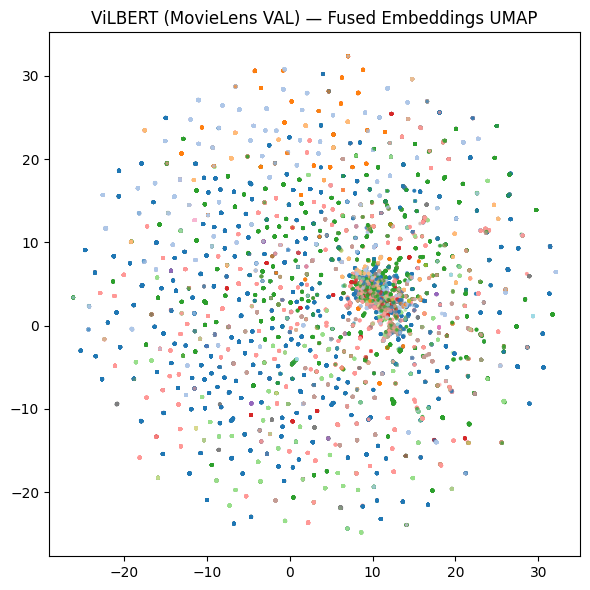

Silhouette (cosine, dominant label): -0.20395486056804657
Mean kNN Jaccard@15: 0.9066756193837027
Median kNN Jaccard@15: 1.0


In [ ]:
# ViLBERT fused embeddings: UMAP + kNN Jaccard

fused_feats = []

def hook_fn(module, inp, out):
    x = inp[0]
    if x.ndim == 3:
        x = x.mean(dim=1)  # pool across tokens
    fused_feats.append(x.detach().cpu())

# find the first Linear layer (usually the first layer in cls_head)
first_linear = None
for name, m in vil_model.named_modules():
    if isinstance(m, torch.nn.Linear):
        first_linear = m
        break

print("Hooking layer:", first_linear)

handle = first_linear.register_forward_hook(hook_fn)

# Run one full pass on val to populate fused_feats
_ = collect_logits_and_labels(vil_model, val_loader, max_batches=None)

handle.remove()

Z = torch.cat(fused_feats, dim=0).numpy()              # (N_val, D_fused)
y_dom = vil_val_labels.numpy().argmax(axis=1)          # dominant genre for coloring

print("Fused embedding shape:", Z.shape)

# UMAP
u = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)
Z2 = u.fit_transform(Z)

plt.figure(figsize=(6, 6))
plt.scatter(Z2[:, 0], Z2[:, 1], c=y_dom, s=3, alpha=0.5, cmap="tab20")
plt.title("ViLBERT (MovieLens VAL) - Fused Embeddings UMAP")
plt.tight_layout()
plt.show()

# Silhouette + kNN label-agreement@15 (dominant label)
Z_std = StandardScaler(with_mean=False).fit_transform(Z)
sil = silhouette_score(Z_std, y_dom, metric="cosine")

nbrs = NearestNeighbors(n_neighbors=15, metric="cosine").fit(Z)
_, idx = nbrs.kneighbors(Z)

# Jaccard on full multi-label sets
Y = vil_val_labels.numpy().astype(int)
jaccs = []
for i in range(Y.shape[0]):
    neigh = Y[idx[i]]
    inter = (neigh & Y[i]).sum(axis=1)
    union = (neigh | Y[i]).sum(axis=1)
    j = np.where(union > 0, inter / union, 0.0).mean()
    jaccs.append(j)

print("Silhouette (cosine, dominant label):", float(sil))
print("Mean kNN Jaccard@15:", float(np.mean(jaccs)))
print("Median kNN Jaccard@15:", float(np.median(jaccs)))

* ViLBERT (text + genome vectors) achieves near-perfect ranking on val set (P@1≈1.0, R@5≈1.0), meaning that model's top predictions are almost always correct and that the complete set of true genres typically appears within the top-5.
* UMAP of fused embeddings shows a dense central cluster with several small groups, which is natural for this multilabel dataset where movies often share multiple genres (on avg, 2.6). kNN Jaccard further confirms strong local label agreement. 

## 4. MVAE 

In [ ]:
import os
from pathlib import Path

import numpy as np
import torch
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    label_ranking_average_precision_score,
)

from comparative.datasets.movielens_datamodule import MovieLensDataModule
from comparative.models.vae.mvae_module import MVAEClassifier

PROJECT_ROOT = "D:/COmparative_Study_of_Multimodal_Represenations"
os.environ["PROJECT_ROOT"] = PROJECT_ROOT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

CKPT_MVAE_MOVIELENS = (
    "D:/COmparative_Study_of_Multimodal_Represenations/"
    "src/comparative/checkpoints/default/movielens_mvae/last.ckpt"
)
print("MVAE MovieLens checkpoint:", CKPT_MVAE_MOVIELENS)

# data module 
dm_mvae_ml = MovieLensDataModule(
    data_dir=Path(PROJECT_ROOT) / "data" / "processed" / "movielens",
    batch_size=256,
    max_len=128,
    model_name="distilbert-base-uncased",
    num_workers=8,
    limit_train_samples=300_000,
    limit_val_samples=60_000,
    balance_by_genre=True,
    seed=42,
    use_genome_vectors=True,
    genome_vectors_path=str(
        Path(PROJECT_ROOT) / "data" / "processed" / "movielens" / "movie_genome_vectors.csv"
    ),
    use_movie_graph_emb=False,
    movie_graph_emb_path=None,
)

dm_mvae_ml.setup()
val_loader_mvae_ml = dm_mvae_ml.val_dataloader()
test_loader_mvae_ml = dm_mvae_ml.test_dataloader()

genre_list_ml = dm_mvae_ml.genre_list
if genre_list_ml is None:
    raise ValueError("dm_mvae_ml.genre_list is None; expected a list of genre names.")
num_genres_ml = len(genre_list_ml)
print("num_genres:", num_genres_ml)
print("genre_list:", genre_list_ml)

# MVAE model 
mvae_ml = MVAEClassifier.load_from_checkpoint(
    CKPT_MVAE_MOVIELENS,
    map_location=DEVICE,
)
mvae_ml = mvae_ml.to(DEVICE)
mvae_ml.eval()

print("Loaded MVAE model from:", CKPT_MVAE_MOVIELENS)
print("multilabel:", getattr(mvae_ml, "multilabel", None))
print("num_labels:", getattr(mvae_ml, "num_labels", None))

DEVICE: cuda
Hybrid MVAE MovieLens checkpoint: C:/Users/ntuke/mydata/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/movielens_mvae/last.ckpt
[MovieLensDataModule] Using 20 genre classes: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
[MovieLensDataModule] Balanced subset: rows=300000 | avg_labels=2.66 | per_genre_target=39973 | min/max per-genre achieved=(0, 120090)
[MovieLensDataModule] Balanced subset: rows=60000 | avg_labels=2.66 | per_genre_target=7992 | min/max per-genre achieved=(0, 24142)
[MovieLensDataModule] Loaded genome vectors: dim=1129 entries=10381
num_genres: 20
genre_list: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance

In [ ]:
from tqdm.auto import tqdm

@torch.no_grad()
def collect_logits_and_labels_mvae(model, loader, max_batches=None):
    """
    Run MVAE on a dataloader and collect:
      - logits: (N, num_labels)
      - labels: (N, num_labels)  (MovieLens multi-hot)
    Works whether forward returns logits or (logits, aux).
    """
    model.eval()
    all_logits = []
    all_labels = []

    for b_idx, batch in enumerate(tqdm(loader, desc="Collecting MVAE logits")):
        # Move tensors to device, keep others as-is
        batch_on_device = {
            k: (v.to(DEVICE) if isinstance(v, torch.Tensor) else v)
            for k, v in batch.items()
        }

        labels = batch_on_device.get("labels", None)
        if labels is None:
            raise RuntimeError("MovieLens batch must contain 'labels' tensor (multi-hot).")

        out = model(batch_on_device)

        # Handle (logits, aux) or just logits
        if isinstance(out, tuple) and len(out) >= 1:
            logits = out[0]
        else:
            logits = out

        all_logits.append(logits.detach().cpu())
        all_labels.append(labels.detach().cpu())

        if (max_batches is not None) and (b_idx + 1) >= max_batches:
            break

    logits_all = torch.cat(all_logits, dim=0).numpy()
    labels_all = torch.cat(all_labels, dim=0).numpy()

    print("Collected logits:", logits_all.shape, "| labels:", labels_all.shape)
    # quick NaN/Inf sanity check
    print("NaNs in logits:", np.isnan(logits_all).any(), " | Infs in logits:", np.isinf(logits_all).any())
    return logits_all, labels_all

# VAL (full 60k)
logits_val_mvae, labels_val_mvae = collect_logits_and_labels_mvae(
    mvae_ml, val_loader_mvae_ml, max_batches=None
)

# TEST (if slow/big, limit max_batches)
logits_test_mvae, labels_test_mvae = collect_logits_and_labels_mvae(
    mvae_ml, test_loader_mvae_ml, max_batches=None
)

Collected logits: (60000, 20) | labels: (60000, 20)
NaNs in logits: False  | Infs in logits: False


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7089a9709360>
Traceback (most recent call last):
  File "C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7089a9709360>
Traceback (most recent call last):
  File "C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "C:/Users/ntuke/.pyenv/ver

Collected logits: (1980045, 20) | labels: (1980045, 20)
NaNs in logits: False  | Infs in logits: False


#### Evaluation on Val & Test -> multilabel metrics

In [3]:
def multilabel_metrics_from_logits(y_true, logits, thr=0.5):
    """
    MovieLens: y_true is multi-hot (N, 20), logits are raw scores (N, 20).
    We apply sigmoid and threshold, then compute standard multilabel metrics.
    """
    # sigmoid
    y_score = 1.0 / (1.0 + np.exp(-logits))
    y_pred = (y_score >= thr).astype(int)

    metrics = {
        "subset_acc": accuracy_score(y_true, y_pred),  # exact match
        "micro_precision": precision_score(y_true, y_pred, average="micro", zero_division=0),
        "micro_recall":    recall_score(y_true,    y_pred, average="micro", zero_division=0),
        "micro_F1":        f1_score(y_true,       y_pred, average="micro", zero_division=0),
        "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "macro_recall":    recall_score(y_true,    y_pred, average="macro", zero_division=0),
        "macro_F1":        f1_score(y_true,       y_pred, average="macro", zero_division=0),
        "mAP_micro":       average_precision_score(y_true, y_score, average="micro"),
        "mAP_macro":       average_precision_score(y_true, y_score, average="macro"),
        "LRAP":            label_ranking_average_precision_score(y_true, y_score),
    }
    return metrics

# VAL
mvae_ml_val_metrics = multilabel_metrics_from_logits(labels_val_mvae, logits_val_mvae, thr=0.5)
print("MVAE (MovieLens) — VAL metrics @0.5")
display(pd.Series(mvae_ml_val_metrics))

# TEST
mvae_ml_test_metrics = multilabel_metrics_from_logits(labels_test_mvae, logits_test_mvae, thr=0.5)
print("MVAE (MovieLens) — TEST metrics @0.5")
display(pd.Series(mvae_ml_test_metrics))

/tmp/ipykernel_5616/1834406960.py:7: RuntimeWarning: overflow encountered in exp
  y_score = 1.0 / (1.0 + np.exp(-logits))
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


MVAE (MovieLens) — VAL metrics @0.5


subset_acc         0.084167
micro_precision    0.856894
micro_recall       0.167486
micro_F1           0.280204
macro_precision    0.804681
macro_recall       0.138227
macro_F1           0.227593
mAP_micro          0.529701
mAP_macro          0.398810
LRAP               0.585065
dtype: float64

/tmp/ipykernel_5616/1834406960.py:7: RuntimeWarning: overflow encountered in exp
  y_score = 1.0 / (1.0 + np.exp(-logits))


MVAE (MovieLens) — TEST metrics @0.5


subset_acc         0.087012
micro_precision    0.838172
micro_recall       0.178041
micro_F1           0.293697
macro_precision    0.778017
macro_recall       0.142478
macro_F1           0.232338
mAP_micro          0.552934
mAP_macro          0.368913
LRAP               0.639884
dtype: float64

In [ ]:
# as for CLIP, perform global threshold sweep (on VAL to find best global thr by micro-F1)
thr_list = [0.3, 0.4, 0.5, 0.6, 0.7]

rows = []
for thr in thr_list:
    m = multilabel_metrics_from_logits(labels_val_mvae, logits_val_mvae, thr=thr)
    rows.append({
        "thr": thr,
        "micro_F1":   m["micro_F1"],
        "macro_F1":   m["macro_F1"],
        "micro_P":    m["micro_precision"],
        "micro_R":    m["micro_recall"],
    })

thr_df = pd.DataFrame(rows).sort_values("thr")
print("MVAE (MovieLens) — VAL global threshold sweep")
display(thr_df)

best_idx = thr_df["micro_F1"].idxmax()
print("Best threshold by micro_F1:", float(thr_df.loc[best_idx, "thr"]))

/tmp/ipykernel_5616/1834406960.py:7: RuntimeWarning: overflow encountered in exp
  y_score = 1.0 / (1.0 + np.exp(-logits))
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/tmp/ipykernel_5616/1834406960.py:7: RuntimeWarning: overflow encountered in exp
  y_score = 1.0 / (1.0 + np.exp(-logits))
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/tmp/ipykernel_5616/1834406960.py:7: RuntimeWarning: overflow encountered in exp
  y_score = 1.0 / (1.0 + np.exp(-logits))
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/tmp/ip

MVAE (MovieLens) — VAL global threshold sweep


,thr,micro_F1,macro_F1,micro_P,micro_R
0,0.3,0.472353,0.310114,0.504430,0.444111
1,0.4,0.394025,0.264959,0.609165,0.291186
2,0.5,0.280204,0.227593,0.856894,0.167486
3,0.6,0.247239,0.206542,0.916990,0.142881
4,0.7,0.214860,0.182767,0.952036,0.121095


Best threshold by micro_F1: 0.3


On MovieLens, MVAE reaches a micro precision of 0.84, micro-recall of 0.18, and micro-F1 of 0.3 at a global threshold of 0.5, with a strict subset accuracy of 0.087. Threshold sweep shows that best threshold is at 0.3, micro-F1 = 0.47. Still, classification metrics are weak, although it learns some structure. 

In [ ]:
# collect latent z + logits + labels (VAL) 

from tqdm.auto import tqdm
import torch
import numpy as np

def collect_latent_and_labels_mvae(model, loader, device=DEVICE, max_batches=None):
    """
    Run MVAE on MovieLens VAL and collect:
      - z: latent vectors (N, latent_dim)
      - logits: (N, num_labels)
      - labels: (N, num_labels) multi-hot
    Assumes MVAEClassifier.forward returns (logits, aux) with aux['z'].
    """
    model.eval()
    all_z, all_logits, all_labels = [], [], []

    with torch.no_grad():
        for b_idx, batch in enumerate(tqdm(loader, desc="Collecting MVAE latent (VAL)")):
            # move tensors to device
            batch_on_device = {
                k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                for k, v in batch.items()
            }

            labels = batch_on_device.get("labels", None)
            if labels is None:
                raise RuntimeError("MovieLens batch must contain 'labels' (multi-hot).")

            out = model(batch_on_device)

            # Expecting (logits, aux) with aux['z']
            if isinstance(out, tuple) and len(out) == 2:
                logits, aux = out
                z = aux.get("z", None)
                if z is None:
                    raise RuntimeError("MVAE forward did not provide aux['z'] for latent analysis.")
            else:
                raise RuntimeError(
                    "Expected MVAEClassifier.forward to return (logits, aux) with aux['z']."
                )

            all_logits.append(logits.detach().cpu())
            all_z.append(z.detach().cpu())
            all_labels.append(labels.detach().cpu())

            if (max_batches is not None) and (b_idx + 1) >= max_batches:
                break

    Z = torch.cat(all_z, dim=0).numpy()          # (N_val, latent_dim)
    LOG = torch.cat(all_logits, dim=0).numpy()   # (N_val, num_labels)
    L = torch.cat(all_labels, dim=0).numpy()     # (N_val, num_labels)

    print("Latent Z (VAL):", Z.shape)
    print("Logits (VAL):  ", LOG.shape)
    print("Labels (VAL):  ", L.shape)
    print("NaNs in Z:", np.isnan(Z).any(), "| Infs in Z:", np.isinf(Z).any())

    return Z, LOG, L

Z_val_ml, logits_val_ml_latent, labels_val_ml_latent = collect_latent_and_labels_mvae(
    mvae_ml, val_loader_mvae_ml, device=DEVICE, max_batches=None   # or limit for speed
)

# dominant label (for coloring / silhouette)
y_multi_ml = labels_val_ml_latent.astype(int)
y_dom_ml = y_multi_ml.argmax(axis=1)

print("Dominant-label vector shape:", y_dom_ml.shape)

Latent Z (VAL): (60000, 128)
Logits (VAL):   (60000, 20)
Labels (VAL):   (60000, 20)
NaNs in Z: False | Infs in Z: False
Dominant-label vector shape: (60000,)


Subset for UMAP/kNN: (20000, 128) | labels: (20000, 20)


C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


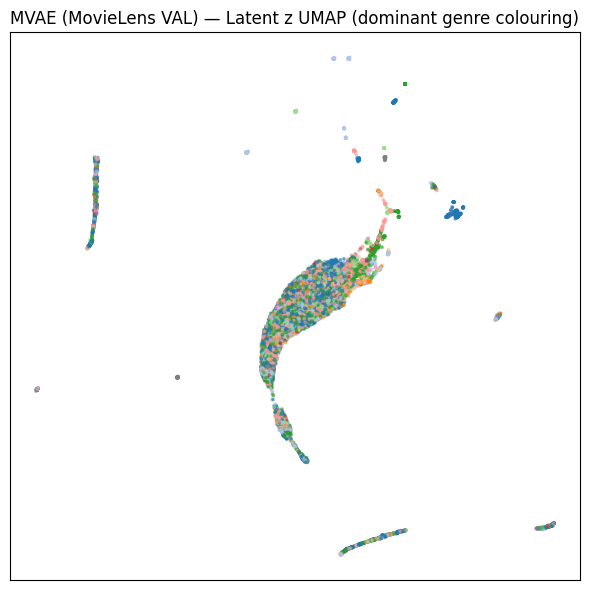

MVAE (MovieLens latent z) — semantic structure
  Silhouette (cosine, dominant label): -0.5743
  Mean kNN Jaccard@15: 0.3144
  Median kNN Jaccard@15: 0.2522


In [ ]:
# 2D UMAP + semantic structure on MVAE latent z (val) ===

import umap
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# optionally can be subsampled for speed (umap on full(60k) can be slower)
N_MAX = 20000
N = Z_val_ml.shape[0]
idx_subset = np.random.choice(N, size=min(N_MAX, N), replace=False)

Z_sub = Z_val_ml[idx_subset]
Y_sub = labels_val_ml_latent[idx_subset].astype(int)
y_dom_sub = y_dom_ml[idx_subset]

print("Subset for UMAP/kNN:", Z_sub.shape, "| labels:", Y_sub.shape)

# --- UMAP 2D ---
u_2d = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)
Z2_ml = u_2d.fit_transform(Z_sub.astype(np.float32))

plt.figure(figsize=(6, 6))
sc = plt.scatter(
    Z2_ml[:, 0], Z2_ml[:, 1],
    c=y_dom_sub, s=3, alpha=0.5, cmap="tab20"
)
plt.title("MVAE (MovieLens VAL) - Latent z UMAP (dominant genre colouring)")
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

# --- Silhouette (dominant label) ---
Z_std = StandardScaler(with_mean=False).fit_transform(Z_sub)
sil_ml = silhouette_score(Z_std, y_dom_sub, metric="cosine")

# --- kNN Jaccard@15 on full multi-label sets ---
nbrs = NearestNeighbors(n_neighbors=15, metric="cosine").fit(Z_sub)
_, idx_knn = nbrs.kneighbors(Z_sub)

jaccs = []
for i in range(Y_sub.shape[0]):
    neigh = Y_sub[idx_knn[i]]
    inter = (neigh & Y_sub[i]).sum(axis=1)
    union = (neigh | Y_sub[i]).sum(axis=1)
    j = np.where(union > 0, inter / union, 0.0).mean()
    jaccs.append(j)

print("MVAE (MovieLens latent z) - semantic structure")
print(f"  Silhouette (cosine, dominant label): {float(sil_ml):.4f}")
print(f"  Mean kNN Jaccard@15: {float(np.mean(jaccs)):.4f}")
print(f"  Median kNN Jaccard@15: {float(np.median(jaccs)):.4f}")

C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


3D UMAP shape: (20000, 3)


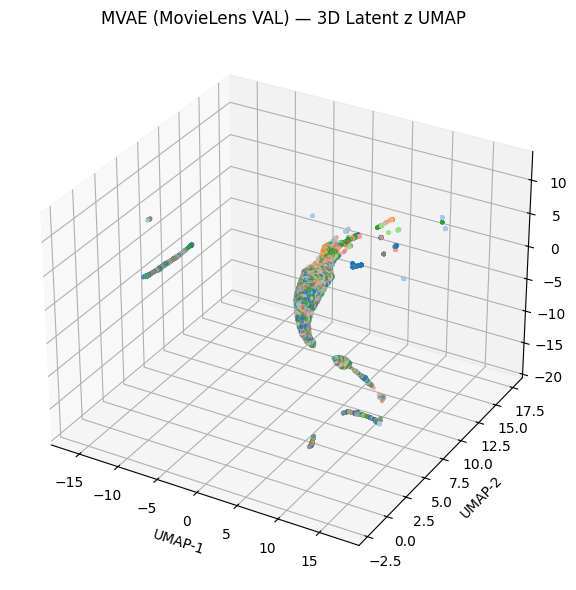

In [ ]:
# 3D UMAP latent visualization for MVAE (val) ===

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D proj)
import matplotlib.pyplot as plt
import umap
import numpy as np

# Use the same subset Z_sub, y_dom_sub from previous cell
u_3d = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    n_components=3,
    random_state=42,
)

Z3_ml = u_3d.fit_transform(Z_sub.astype(np.float32))
print("3D UMAP shape:", Z3_ml.shape)

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")

p = ax.scatter(
    Z3_ml[:, 0], Z3_ml[:, 1], Z3_ml[:, 2],
    c=y_dom_sub, s=4, alpha=0.5, cmap="tab20"
)

ax.set_title("MVAE (MovieLens VAL) - 3D Latent z UMAP")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.show()

In the UMAP projections above colors represent dominant genre of each sample.

1. In 2D UMAP (latent space) we see that genres don't form tight/separable clusters, colors are mixed -> overlapping regions. It's natural because dataset is multilabel (on avg., 2.6 genres per movie). Genre is 

2. In 3D UMAP (latent z) we have a better view of several "thin" branches associated with rarer genres (e.g., IMAX, documentary), yet the overall structure remains non-clustered.

3. Silhouette & kNN‑Jaccard
* Negative silhouette (-0.57) is expected for this multilabel dataset, genres overlapping
* knn Jaccard@15 (how many genres do 15 neighbors share with a sample) of 0.32 is moderate, there is an exisiting local structure -> neighbors often share genres.
* Overall conclusion for these scores: no global clusters (neg silh), local neighborhoods carry genre meaning (knn score)